In [3]:
!pip install tensorflow==2.15.0
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [1]:
import tensorflow as tf
import gc
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Activation, BatchNormalization, LSTM, ConvLSTM2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Lambda, Reshape, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, TerminateOnNaN, LearningRateScheduler, CSVLogger
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras import preprocessing
from keras.applications import imagenet_utils
import pandas as pd
import numpy as np
import random
import keras
import shutil
import pathlib
import itertools
import cv2
import os
import matplotlib.image as mpimg
import seaborn as sns

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"berkekaradumann","key":"8283b4661f848d876de1cadbb70e5def"}'}

In [13]:
!pip install kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/.kaggle'
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/Tr-g

In [19]:
train_dir = 'Training/'
test_dir = 'Testing/'

In [20]:
for dirpath, dirnames, filenames in os.walk(train_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 0 images in 'Training/'.
There are 0 directories and 1321 images in 'Training/glioma'.
There are 0 directories and 1457 images in 'Training/pituitary'.
There are 0 directories and 1339 images in 'Training/meningioma'.
There are 0 directories and 1595 images in 'Training/notumor'.


In [21]:
for dirpath, dirnames, filenames in os.walk(test_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 0 images in 'Testing/'.
There are 0 directories and 300 images in 'Testing/glioma'.
There are 0 directories and 300 images in 'Testing/pituitary'.
There are 0 directories and 306 images in 'Testing/meningioma'.
There are 0 directories and 405 images in 'Testing/notumor'.


In [22]:
def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");
  print(f"Image shape: {img.shape}")
  return img

Image shape: (512, 512, 3)


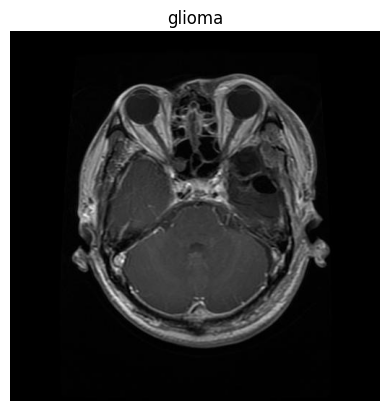

In [23]:
img = view_random_image(target_dir=test_dir,
                        target_class="glioma")

In [24]:
EPOCHS = 50
from math import floor
N_FOLDS = 5
INIT_LR = 1e-3
T_BS = 16
V_BS = 16
decay_rate = 0.95
decay_step = 1
IMAGE_SIZE = [224,224]

In [25]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

def augment_image(image, label):
    # Apply augmentation transformations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)

    # Apply the width and height shifts
    width_shift = tf.random.uniform([], -0.2, 0.2) * tf.cast(tf.shape(image)[1], tf.float32)
    height_shift = tf.random.uniform([], -0.2, 0.2) * tf.cast(tf.shape(image)[0], tf.float32)
    image = tfa.image.translate(image, [width_shift, height_shift])

    return image, label

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [26]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 batch_size=32,
                                                                 image_size=IMAGE_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SIZE,
                                                                shuffle=False)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [27]:
# Apply augmentation to the training dataset using the map function
train_dataset_augmented = train_data.map(augment_image)

In [ ]:
# def Combined_model():
#     # Input layer
#     input_layer = Input(shape=(224, 224, 3))

#     # Base VGG19 model as a feature extractor
#     baseModel = VGG19(weights=None, include_top=False, input_tensor=input_layer)

#     # Load the weights from the local file (specify the path)
#     baseModel.load_weights('/kaggle/input/vgg19-weight/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

#     # Freeze the layers of the VGG19 model
#     for layer in baseModel.layers:
#         layer.trainable = False

#     x = baseModel.output

#     # LSTM layer
#     x = Reshape((49, 512))(x)
#     x = LSTM(512, activation="relu", return_sequences=True, trainable=False)(x)
#     x = BatchNormalization()(x)

#     # FC layer
#     x = Flatten(name="flatten")(x)

#     # fc1 layer
#     x = Dense(units=4096, activation='relu')(x)
#     x = BatchNormalization()(x)

#     # fc2 layer
#     x = Dense(units=4096, activation='relu')(x)
#     x = BatchNormalization()(x)

#     # Output layer
#     output = Dense(units=4, activation='softmax')(x)

#     model = Model(inputs=input_layer, outputs=output)
#     opt = Adam(lr=1e3)
#     model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

#     return model

# # Create the model
# model = Combined_model()

# # Print the model summary
# model.summary()

In [29]:
def Combined_model():
    # Input layer
    input_layer = Input(shape=(224, 224, 3))

    # Base VGG19 model as a feature extractor with pre-trained weights
    baseModel = VGG19(weights='imagenet', include_top=False, input_tensor=input_layer)

    # Freeze the layers of the VGG19 model
    for layer in baseModel.layers:
        layer.trainable = False

    x = baseModel.output

    # LSTM layer
    x = Reshape((49, 512))(x)
    x = LSTM(512, activation="relu", return_sequences=True, trainable=False)(x)
    x = BatchNormalization()(x)

    # FC layer
    x = Flatten(name="flatten")(x)

    # fc1 layer
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)

    # fc2 layer
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)

    # Output layer
    output = Dense(units=4, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    opt = Adam(learning_rate=1e-3)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

    return model

# Create the model
model = Combined_model()

# Print the model summary
model.summary()


80134624/80134624 [==============================] - 3s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [30]:
checkpoint = [ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy',mode='max',verbose=1,save_best_only=True,save_weights_only=True),
             LearningRateScheduler(lambda epoch : INIT_LR * pow(decay_rate, floor(epoch / decay_step)))]
earlystop = EarlyStopping(monitor='accuracy', min_delta=0, patience=15, verbose=1, mode='max')

In [31]:
history = model.fit(train_dataset_augmented,
                    epochs=50,
                    steps_per_epoch=len(train_dataset_augmented),
                    validation_data = test_data,
                    callbacks=[checkpoint])

Epoch 1/50
179/179 [==============================] - ETA: 0s - loss: 1.1500 - accuracy: 0.7686
Epoch 1: val_accuracy improved from -inf to 0.82990, saving model to best_model.h5
179/179 [==============================] - 77s 354ms/step - loss: 1.1500 - accuracy: 0.7686 - val_loss: 0.8190 - val_accuracy: 0.8299 - lr: 0.0010
Epoch 2/50
179/179 [==============================] - ETA: 0s - loss: 0.4965 - accuracy: 0.8361
Epoch 2: val_accuracy improved from 0.82990 to 0.84973, saving model to best_model.h5
179/179 [==============================] - 53s 292ms/step - loss: 0.4965 - accuracy: 0.8361 - val_loss: 0.5103 - val_accuracy: 0.8497 - lr: 9.5000e-04
Epoch 3/50
179/179 [==============================] - ETA: 0s - loss: 0.3816 - accuracy: 0.8710
Epoch 3: val_accuracy improved from 0.84973 to 0.88024, saving model to best_model.h5
179/179 [==============================] - 59s 328ms/step - loss: 0.3816 - accuracy: 0.8710 - val_loss: 0.3383 - val_accuracy: 0.8802 - lr: 9.0250e-04
Epoch 4/

In [32]:
model.load_weights('best_model.h5')
_, accuracy = model.evaluate(test_data)
print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

41/41 [==============================] - 7s 170ms/step - loss: 0.1411 - accuracy: 0.9794
Validation accuracy: 97.94%


In [33]:
pred_probs = model.predict(test_data, verbose=1)

41/41 [==============================] - 7s 165ms/step


In [34]:
pred_classes = pred_probs.argmax(axis=1)

y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [35]:
target_names = ['Glioma', 'Meningioma', 'No Tumor','Pituitary']
print(classification_report(y_labels,
                            pred_classes,
                            target_names=target_names, digits=4))

              precision    recall  f1-score   support

      Glioma     0.9894    0.9300    0.9588       300
  Meningioma     0.9352    0.9902    0.9619       306
    No Tumor     1.0000    0.9975    0.9988       405
   Pituitary     0.9900    0.9933    0.9917       300

    accuracy                         0.9794      1311
   macro avg     0.9786    0.9778    0.9778      1311
weighted avg     0.9802    0.9794    0.9794      1311



In [36]:
cm = confusion_matrix(y_labels,pred_classes)

TP = cm[0, 0]
TN = cm[1:, 1:].sum()
FP = cm[0, 1:].sum()
FN = cm[1:, 0].sum()

Population = TN+FN+TP+FP
spesificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)

print("True Positives:", TP)
print("False Positives:", FP)
print("True Negatives:", TN)
print("False Negatives:", FN)
print("Specificity:", spesificity)
print("Sensitivity:", sensitivity)

True Positives: 279
False Positives: 21
True Negatives: 1008
False Negatives: 3
Specificity: 0.9795918367346939
Sensitivity: 0.9893617021276596


In [37]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(20, 20), text_size=15, norm=False, savefig=False):

  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  ax.grid(False)

  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels)

  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

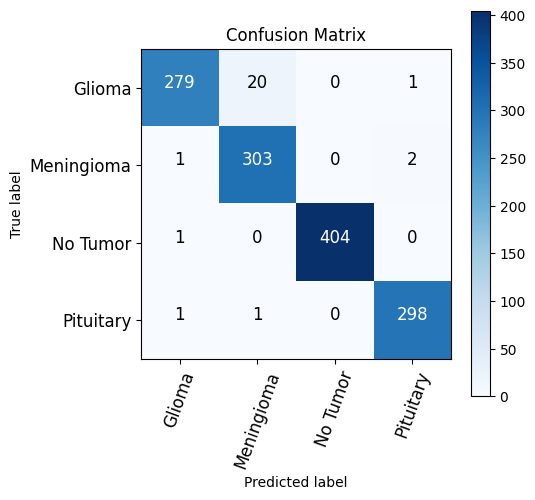

In [38]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=target_names,
                      figsize=(5, 5),
                      text_size=12,
                      norm=False,
                      savefig=True)

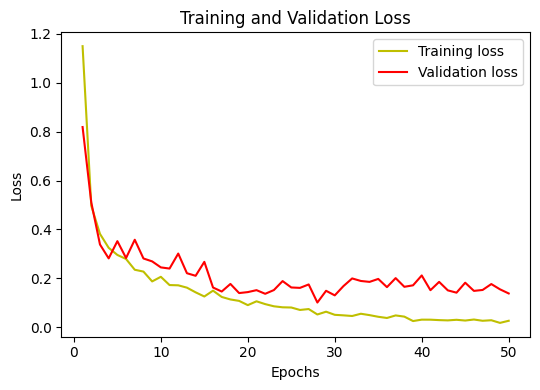

In [39]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(5.5, 4))

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(False)

plt.tight_layout()
plt.show()

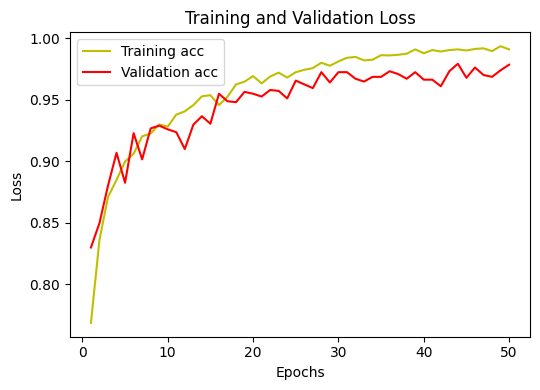

In [40]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(5.5, 4))

plt.plot(epochs, loss, 'y', label='Training acc')
plt.plot(epochs, val_loss, 'r', label='Validation acc')
plt.title('Training and Validation Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(False)

plt.tight_layout()
plt.show()